In [1]:
# Part 0 - Creeu un Jupyter notebooks i configureu una connexió amb l'escena Coppelia.
import coppeliasim_zmqremoteapi_client
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import numpy as np

def connect(port=23000):
    try:
        client = RemoteAPIClient('127.0.0.1', port)
        print(f"Connected to CoppeliaSim on port {port}")
        return client
    except Exception as e:
        print(f"Could not connect to CoppeliaSim on port {port}: {e}")
        return None

client = connect()
sim = client.getObject('sim')

# Obtenim joint handlers
joints = [sim.getObjectHandle(f'/m{i+1}') for i in range(6)]

# Obtenir vision sensor handler
vision_sensor = sim.getObjectHandle('/Vision_sensor')

# Obtenir handles dels cubs
cubes = [sim.getObjectHandle(f'/Cuboid[{i}]') for i in range(4)]

# Obtenir handlers de les safates
planes = [sim.getObjectHandle(f'/Plane[{i}]') for i in range(4)]

print("Joint handles:", joints)
print("Vision sensor handle:", vision_sensor)
print("Cube handles:", cubes)
print("Plane handles:", planes)

# Llista tots els shapes i dummies sota el joint 3
print("Tots els objectes sota joints[2]:")
for obj_type in [sim.object_shape_type, sim.object_dummy_type]:
    for h in sim.getObjectsInTree(joints[2], obj_type):
        alias = sim.getObjectAlias(h)
        pos   = sim.getObjectPosition(h, -1)
        print(f"  {alias:60s} pos={pos}")

Connected to CoppeliaSim on port 23000
Joint handles: [16, 18, 20, 22, 24, 26]
Vision sensor handle: 38
Cube handles: [29, 30, 39, 44]
Plane handles: [40, 41, 42, 43]
Tots els objectes sota joints[2]:
  section_2_respondable                                        pos=[0.02535611299389729, -0.006323254126921291, 0.1018548355712042]
  section_2_visual                                             pos=[0.02529538507870159, -0.006124716194046141, 0.1021241149034022]
  section_3_respondable                                        pos=[0.06062848698169909, -0.008979166769380792, 0.08071391382334489]
  section_3_visual                                             pos=[0.06023383419384203, -0.010744644836563195, 0.08123501635660921]
  holder_section_respondable                                   pos=[0.11655654074812413, -0.016221437326058685, 0.08432643364425851]
  holder_section_visual                                        pos=[0.11716183092397825, -0.01670259502675994, 0.08446738162605599]
  ho

In [2]:
# Part 0 -  i feu moure tots els motors del robot.

import time

# Exemple: Movem cada articulació a una posició diferent i després torneu-la a zero
target_positions = [0.5, -0.5, 0.5, -0.5, 0.5, -0.5]  # radians

# Movem a les posicions objectiu
for joint, pos in zip(joints, target_positions):
    sim.setJointTargetPosition(joint, pos)
print("Moved joints to target positions.")
time.sleep(2)  # Wait for 2 seconds to observe the movement

# Moveu de nou a zero
for joint in joints:
    sim.setJointTargetPosition(joint, 0)
print("Moved joints back to zero.")

# posem la pinsa a 15
sim.setJointTargetPosition(joints[5], 15 * np.pi/180)

Moved joints to target positions.
Moved joints back to zero.


1

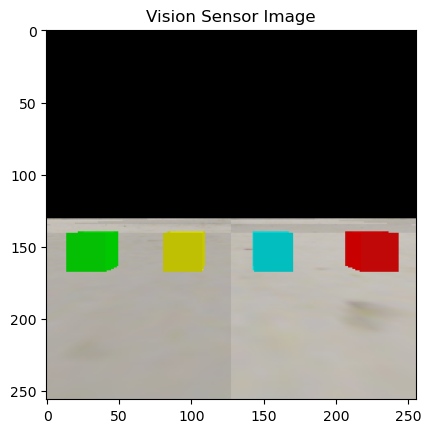

In [3]:
# Part 1 - capturem imatge del sensor
import cv2
import matplotlib.pyplot as plt

img, resX, resY = sim.getVisionSensorCharImage(vision_sensor)

# Convertim la imatge a un array de NumPy i la reformatem
image = np.frombuffer(img, dtype=np.uint8).reshape(resY, resX, 3)
image = np.flipud(image)  # Flip vertically if needed

# Mostra la imatge per verificar-la (el robot ha de estar en simulació)
import matplotlib.pyplot as plt
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.imshow(image)
plt.title("Vision Sensor Image")
plt.show()

Green cube:
  Detected image position: (x=32, y=154), size (w=36, h=28)
  Estimated world position: (x=0.175, y=0.075), distance=0.190 m
  Simulation world position: (x=0.175, y=0.075, z=0.010)
------------------------------------------------------------
Yellow cube:
  Detected image position: (x=95, y=154), size (w=29, h=28)
  Estimated world position: (x=0.175, y=0.026), distance=0.177 m
  Simulation world position: (x=0.176, y=-0.022, z=0.010)
------------------------------------------------------------
Cyan cube:
  Detected image position: (x=157, y=154), size (w=28, h=28)
  Estimated world position: (x=0.175, y=-0.023), distance=0.176 m
  Simulation world position: (x=0.177, y=-0.077, z=0.010)
------------------------------------------------------------
Red cube:
  Detected image position: (x=225, y=154), size (w=37, h=28)
  Estimated world position: (x=0.175, y=-0.076), distance=0.191 m
  Simulation world position: (x=0.175, y=0.025, z=0.010)
-------------------------------------

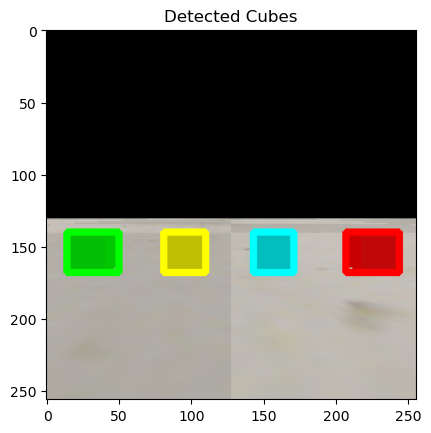

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Definim els rangs de color en RGB
color_ranges = {
    "green":  (np.array([0, 120, 0]),   np.array([100, 255, 100])),
    "yellow": (np.array([180, 180, 0]), np.array([255, 255, 120])),
    "cyan":   (np.array([0, 180, 180]), np.array([80, 255, 255])),
    "red":    (np.array([180, 0, 0]),   np.array([255, 80, 80]))
}

# Per a la visualització, assignem un color a cada caixa delimitadora
box_colors = {
    "green":  (0, 255, 0),
    "yellow": (255, 255, 0),
    "cyan":   (0, 255, 255),
    "red":    (255, 0, 0)
}

# Mapejem el nom dels colors als índexs dels cubs a la simulació
cube_indices = {
    "cyan": 0,
    "yellow": 1,
    "red": 2,
    "green": 3
}

# Obtenim les posicions reals de la simulació
cube_positions_sim = {}
for color, idx in cube_indices.items():
    pos = sim.getObjectPosition(cubes[idx], -1)
    cube_positions_sim[color] = pos

# Calibració: mapeig de x de la imatge (píxels) a y en el món (metres)
def img_to_world(cx, cy):
    # Mapeig lineal per a y_món (lateral)
    m = -0.00078125
    c = 0.1
    y_world = m * cx + c
    # x_món és constant per aquesta configuració (tots els cubs a la mateixa profunditat)
    x_world = 0.175
    # Distància real des de la càmera (0,0) al centre del cub
    d = np.sqrt(x_world**2 + y_world**2)
    return x_world, y_world, d

# Detecta els cubs a la imatge i compara les posicions
image_with_boxes = image.copy()
cube_count = 0
detected_positions = {}
estimated_world_positions = {}

for color, (low, high) in color_ranges.items():
    mask = cv2.inRange(image, low, high)
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    cnts = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[-2]
    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        if w > 10 and h > 10:
            cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), box_colors[color], 3)
            cx, cy = x + w // 2, y + h // 2
            detected_positions[color] = (cx, cy)
            # Estimem la posició al món des de la imatge
            xw, yw, dist = img_to_world(cx, cy)
            estimated_world_positions[color] = (xw, yw, dist)
            # Obtenim la posició de la simulació
            sim_pos = cube_positions_sim[color]
            print(f"{color.capitalize()} cube:")
            print(f"  Detected image position: (x={cx}, y={cy}), size (w={w}, h={h})")
            print(f"  Estimated world position: (x={xw:.3f}, y={yw:.3f}), distance={dist:.3f} m")
            print(f"  Simulation world position: (x={sim_pos[0]:.3f}, y={sim_pos[1]:.3f}, z={sim_pos[2]:.3f})")
            print("-" * 60)
            cube_count += 1

print(f"Total cubes detected: {cube_count}")
plt.imshow(image_with_boxes)
plt.title("Detected Cubes")
plt.show()

In [5]:
# Obtenim les posicions de les safates/planos
tray_names = ['yellow', 'red', 'green', 'blue']
tray_positions = {}

for i, color in zip([3, 2, 1, 0], tray_names):
    pos = sim.getObjectPosition(planes[i], -1)  # -1 indica el marc mundial
    tray_positions[color] = pos
    print(f"{color.capitalize()} tray (Plane[{i}]) position: {pos}")


Yellow tray (Plane[3]) position: [0.05000000447034836, 0.11999999731779099, 0.0020000000949949026]
Red tray (Plane[2]) position: [-0.09999997913837433, 0.11999999731779099, 0.0020000000949949026]
Green tray (Plane[1]) position: [0.05000000447034836, -0.11999999731779099, 0.0020000000949949026]
Blue tray (Plane[0]) position: [-0.10000000149011612, -0.11999999731779099, 0.0020000000949949026]


In [6]:
 #Provem a tocar el dummy amb la punta de la pinsa

import math, time
import numpy as np

# ──────────────────────────────────────────────────
# 1) valors manuals (en graus, excepte m6 en rad)
manual_deg = [
    23,    # m1 (base)
    0,    # m2 (braç superior)
    0,     # m3 (colze)
    0,     # m4 (roll canell)
   110,    # m5 (pitch canell)
    0.12   # m6 (pinça)
]
# ──────────────────────────────────────────────────

# 2) Converteim graus a radians
manual_rad = [math.radians(a) for a in manual_deg[:5]] + [manual_deg[5]]

# 3) Movem
for j_handle, ang in zip(joints, manual_rad):
    sim.setJointTargetPosition(j_handle, ang)
time.sleep(0.5)



In [7]:
def cinematica_inversa(x, y, z):
    # Constants geomètriques del robot
    b = 0.15   # Longitud del braç L1 + extensió fins al dummy
    ab = 0.05  # Longitud de l'avantbraç L2
    H = 0.05   # Alçada de la base
    #correcio

    # Càlcul de l'eix 1 (rotació de base)
    Axis1 = math.atan2(y, x)
    xprima = math.sqrt(x**2 + y**2)
    B = xprima
    A = z - H

    # Hipotenusa del triangle format pel braç
    Hip = math.sqrt(A**2 + B**2)

    # Angles intermedis per calcular el segon eix
    alfa = math.atan2(A, B)
    beta = math.acos((b**2 - ab**2 + Hip**2) / (2 * b * Hip))
    Axis2 = alfa + beta

    # Càlcul del tercer eix (avantbraç)
    gamma = math.acos((b**2 + ab**2 - Hip**2) / (2 * b * ab))
    Axis3 = gamma

    # Conversió dels angles a graus
    Axis1Grados = Axis1 * 180 / math.pi        # Giro base en graus
    Axis2Grados = 90 - Axis2 * 180 / math.pi   # Giro braç en graus
    Axis3Grados = 180 - Axis3 * 180 / math.pi  # Giro avantbraç en graus

    # Retornem els angles en un array
    ciGraus = [Axis1Grados, Axis2Grados, Axis3Grados]
    return ciGraus

In [8]:
import math, time
import numpy as np

def moure(x, y, z):
    # 1) Calcular angles amb la cinemàtica inversa
    angles_ci = cinematica_inversa(x, y, z)  # Retorna [m1, m2, m3] en graus

    # 2) Convertir a radians
    angles_rad = [math.radians(a) for a in angles_ci]

    print("Movent el robot a angles (º):", angles_ci)

    # 3) Aplicar només als tres primers eixos
    for i in range(3):
        time.sleep(1)
        sim.setJointTargetPosition(joints[i], angles_rad[i])
        print(f"Movent eix {i+1} a {round(angles_ci[i], 2)}º...")


    # 4) Verificació posicional
    tip_hdl = sim.getObjectHandle('holder_visual')
    p_tip = np.array(sim.getObjectPosition(tip_hdl, -1))
    p_obj = np.array([x, y, z])
    dist = np.linalg.norm(p_tip - p_obj)
    print(f"Distància punta-objectiu: {dist:.4f} m")

def aixecar():
    angle_deg = 30          # graus que vols
    angle_rad = angle_deg * np.pi/180.0   # passem a radians
    sim.setJointTargetPosition(joints[1], angle_rad)


def baixar():
    angle_deg = 10          # graus que vols
    angle_rad = angle_deg * np.pi/180.0   # passem a radians
    sim.setJointTargetPosition(joints[4], angle_rad)

def deixar():
    # 1) Inclina la pinssa 10°
    m5_deg  = 10
    m5_rad  = m5_deg * np.pi / 180
    sim.setJointTargetPosition(joints[4], m5_rad)

    # 2) Obre la pinça (m6): valor petit en radians
    sim.setJointTargetPosition(joints[5], 0.02)  



    


In [9]:
#anem pel blau
xw, yw, dist = estimated_world_positions['cyan']
zw = 0.06 #fem servir la alçada estimada
moure(xw+0.01,yw,zw)
before = sim.getJointPosition(joints[4])   # en radians
print(f"m5 abans: {np.degrees(before):.1f}°")
time.sleep(2)
#baixem pinsa
#baixar()
#tanquem pinsa
sim.setJointTargetPosition(joints[5], 0.12)   # o el valor que tanca de debò
time.sleep(1)
# truqillo pare-fill
cub_cyan  = sim.getObject('/Cuboid[2]')      # el cub blau/cyan
gripper    = sim.getObject('/base_link_respondable/holder_visual')
sim.setObjectParent(cub_cyan, gripper, True) # keepInPlace = True

time.sleep(1)
aixecar()


Movent el robot a angles (º): [-6.982030401760809, 75.26248992438579, 49.013055383291686]
Movent eix 1 a -6.98º...
Movent eix 2 a 75.26º...
Movent eix 3 a 49.01º...
Distància punta-objectiu: 0.0204 m
m5 abans: 110.0°


In [ ]:
angle_deg = 30          # graus que vols
angle_rad = angle_deg * np.pi/180.0   # passem a radians
#sim.setJointTargetPosition(joints[4], angle_rad)
#sim.setJointTargetPosition(joints[5], 15 * np.pi/180)

In [ ]:
blue_tray =sim.getObjectPosition(planes[0], -1) # posicio tray blue
print(blue_tray)
moure (blue_tray[0],blue_tray[1],0.1)